In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from resipy import Project
from gp_tools.ert.utils import plot_pseudosection, extract_data, reconstruct_data, OHMfile
from gp_tools.ert.gap_filling.knn_imputer import KNNfiller

API path =  c:\Users\peter\miniforge3\envs\general_gp\Lib\site-packages\resipy
ResIPy version =  3.6.1
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.


In [2]:
if Path('original').exists():
    k = Project(typ='R2', dirname='./temp_dir')
    run_original = False
else:
    k = Project(typ='R2', dirname='./original')
    run_original = True

k.createSurvey(fname='test.ohm', ftype='BERT')

original_df, electrodes, original_data = extract_data(k)


Working directory is: c:\Users\peter\Documents\02_coding\02_Geophysics\geophysics_repo\tutorials\ERT\temp_dir
filterData: 0 / 3080 quadrupoles removed.
3080/3080 reciprocal measurements found.
500 measurements error > 20 %


C:\Users\peter\Documents\02_coding\02_Geophysics\geophysics_repo\src\gp_tools\ert\utils.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recip_data['rhoa'] = recip_data['recipMean'].values * recip_data['K'].values


In [3]:
k.filterElec([50])

filterData: 204 / 3080 quadrupoles removed.
204 measurements removed!


204

C:\Users\peter\Documents\02_coding\02_Geophysics\geophysics_repo\src\gp_tools\ert\utils.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recip_data['rhoa'] = recip_data['recipMean'].values * recip_data['K'].values
c:\Users\peter\miniforge3\envs\general_gp\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


filterData: 842 / 2876 quadrupoles removed.
842 measurements with greater than 15.0% reciprocal error removed!
Error model is R_err = 0.067*R_avg + 5.97e-05 (R^2 = 0.999)


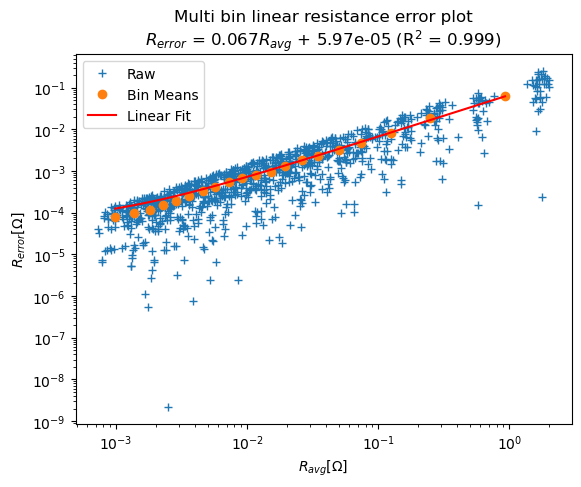

In [4]:
k.filterRecip(15)
filtered_df, _, _ = extract_data(k)

k.fitErrorLin()

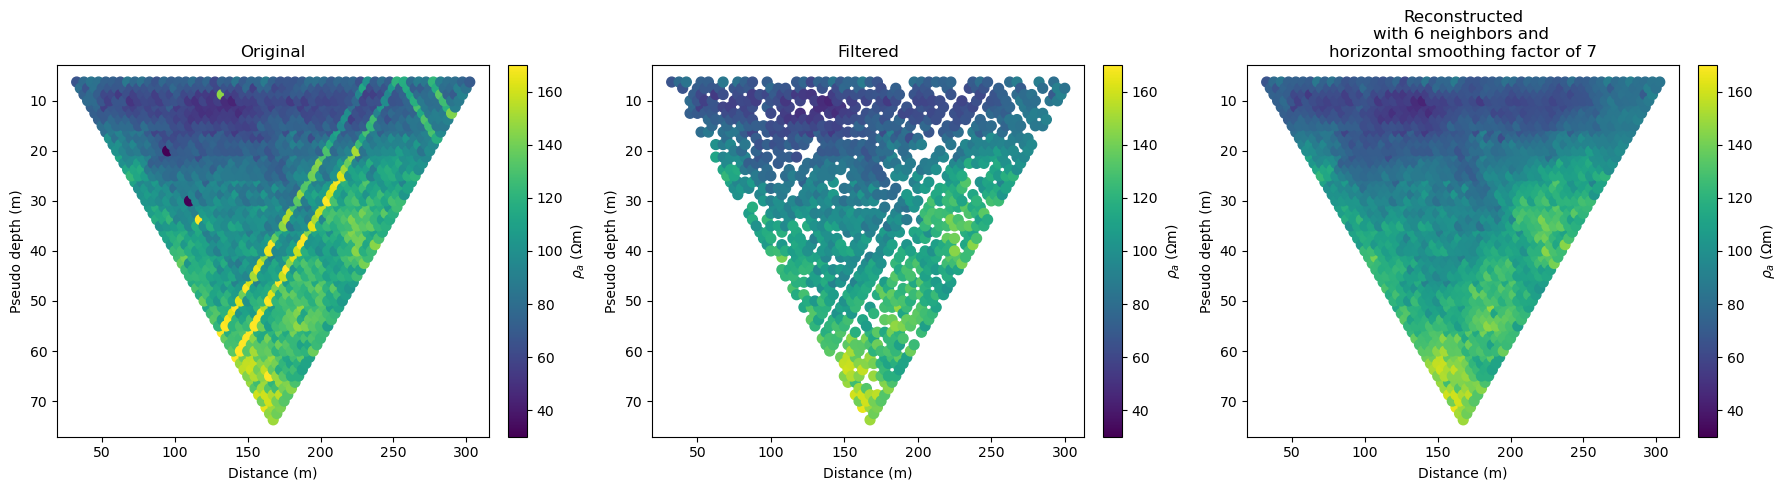

In [5]:
neighbors = 6
horizontal_weight = 7

merged_df = original_df.merge(
    filtered_df,
    on=['x', 'y'],
    how="left",
    suffixes=("_drop", "")
)
merged_df.drop(columns='rhoa_drop', inplace=True)

imputer = KNNfiller(neighbors=neighbors, horizontal_weight=horizontal_weight)
imputed_df = imputer.fit_transform(merged_df)

fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].set_title('Original')
ax[1].set_title(f'Filtered')
ax[2].set_title(f'Reconstructed\nwith {neighbors} neighbors and \nhorizontal smoothing factor of {horizontal_weight}')

plot_pseudosection(original_df, ax=ax[0], vmin=30, vmax=170)
plot_pseudosection(filtered_df, ax=ax[1], vmin=30, vmax=170)
plot_pseudosection(imputed_df, ax=ax[2], vmin=30, vmax=170)
fig.tight_layout()

misfit = np.sqrt(((original_df['rhoa'].values - imputed_df['rhoa'].values)**2).sum()) / len(original_df)


In [6]:
reconstructed_data = reconstruct_data(original_data, imputed_df)
reconstructed_data.rename(columns={'resist': 'r'}, inplace=True)
_ = OHMfile.write('reconstructed.ohm', electrodes=electrodes, data=reconstructed_data)

File already exists. Overwritting.


In [7]:
do_results = False

if do_results:
    if run_original:
        k.invert()
    else:
        k.loadResults('./original/invdir')

    k.showResults(sens=False, index=0)

In [8]:
if do_results:
    if Path('reconstructed').exists():
        k2 = Project(dirname='./temp_dir', typ='R2')
        k2.loadResults('./reconstructed/invdir')
    else:
        k2 = Project(dirname='./reconstructed', typ='R2')
        k2.createSurvey(fname='reconstructed.ohm', ftype='BERT')
        k2.invert()

    k2.showResults(sens=False, index=0)

In [9]:
fig.savefig('reconstruction_test.png', dpi=300)